In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(1)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
#from src.model import SSCNetwork
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, get_sample_from_num_swaps
from src.utils.general_old import get_selectivity, get_cos_sim_torch, get_selectivity_accuracy

In [3]:
from network_parameters import network_parameters


In [4]:
recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1000
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [5]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [6]:
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [7]:
torch.save(network, "network_7.pt")
network = torch.load("network_7.pt", weights_only=False)

In [8]:
input_params = {}
input_params["num_days"] = 500
input_params["day_length"] = 100
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [9]:
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
50
100
150
200
250
300
350
400
450


In [19]:
def get_selectivity(recordings, latents):
    # Flatten time
    _, num_neurons = recordings.shape


    days, day_length, num_latents = latents.shape

    recordings_flat = recordings.reshape(-1, num_neurons).float()    # shape: (days * day_length, num_neurons)
    latents_flat = latents.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)


    # Normalize (zero mean, unit variance)
    latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
    recordings_norm = (recordings_flat - recordings_flat.mean(dim=0)) / recordings_flat.std(dim=0)


    # Compute correlation (selectivity): (num_neurons, num_latents)
    selectivity = recordings_norm.T @ latents_norm / latents_norm.shape[0]


    return selectivity


def get_ordered_indices(recordings, latents, threshold=0.9):
    selectivity = get_selectivity(recordings, latents)
    num_neurons, num_latents = selectivity.shape

    # Identify the latent with the highest selectivity per neuron
    max_selectivity, max_latent_idx = selectivity.max(dim=1)

    # Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
    assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

    # Generate reordered indices
    ordered_indices = []

    # Iterate over each latent to collect selective neurons
    for latent in range(num_latents):
        latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
        ordered_indices.append(latent_neurons)

    # Add non-selective neurons at the end
    non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
    ordered_indices.append(non_selective_neurons)

    # Concatenate indices into a single ordering
    ordered_indices = torch.cat(ordered_indices)

    return selectivity, ordered_indices

In [10]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

X_episodes = F.one_hot(input_episodes[-100:].long(), num_classes=np.prod(latent_specs["dims"]))



network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)
network.selectivity_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes, assembly_size=10)


#network.selectivity_ctx, network.ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB)
#network.selectivity_mtl_sparse, network.ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB)
#network.selectivity_mtl_dense, network.ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB)
#network.selecitivty_ctx_episodes, network.ordered_indices_ctx_episodes = get_ordered_indices(X_ctx, X_episodes)

(array([ 50.,   0.,   0.,   0.,   0.,   0., 100.,   0.,   0., 250.]),
 array([0.        , 0.10000457, 0.20000914, 0.30001369, 0.40001827,
        0.50002283, 0.60002738, 0.70003194, 0.80003655, 0.9000411 ,
        1.00004566]),
 <BarContainer object of 10 artists>)

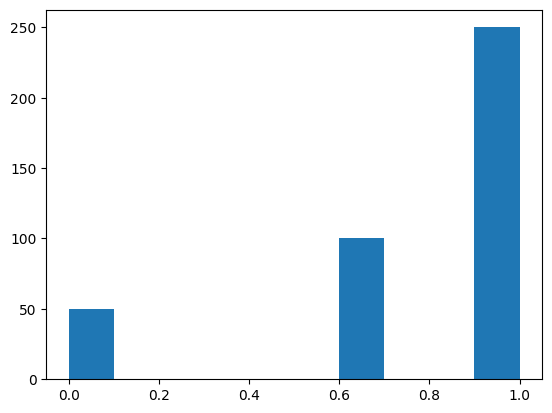

In [11]:
plt.hist((network.selectivity_ctx_episodes.max(axis=1)[0]).flatten())

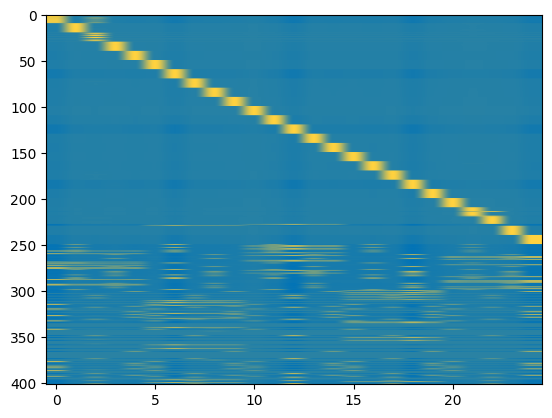

In [32]:
plt.imshow(network.selecitivty_ctx_episodes[network.ordered_indices_ctx_episodes], cmap=blue_yellow, aspect='auto')

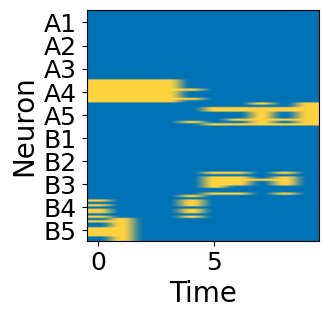

In [22]:
fig = plt.figure(figsize=(3, 3))


plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A][-10:, :100].reshape(-1, 100).T, aspect='auto', cmap=blue_yellow)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5  # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 5], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/7b1.svg', dpi=300, transparent=True)

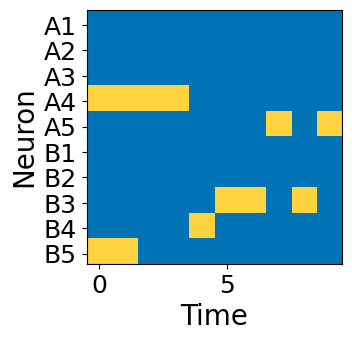

In [23]:
fig = plt.figure(figsize=(3.3, 3.3))


plt.imshow(torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A, 100:][-10:][:, network.ordered_indices_mtl_sparse][:, :50].reshape((-1, 50)).T, aspect='auto', cmap=blue_yellow)
# Example parameters
N = 50  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 5], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig('Figures_SVG/7b2.svg', dpi=300, transparent=True)

In [12]:
full_ordered_indices_ctx = torch.cat([
    network.ordered_indices_ctx[:100],
    network.ordered_indices_ctx_episodes[:250]
])

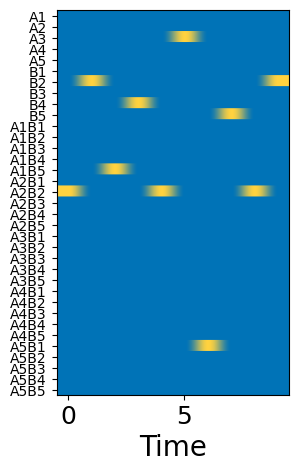

In [13]:
fig = plt.figure(figsize=(3, 5))


plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A][-10:][:, full_ordered_indices_ctx].reshape((-1, 350)).T, aspect='auto', cmap=blue_yellow)



# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)

plt.xticks([0, 5], fontsize=18)
plt.xlabel("Time", fontsize=20)

plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

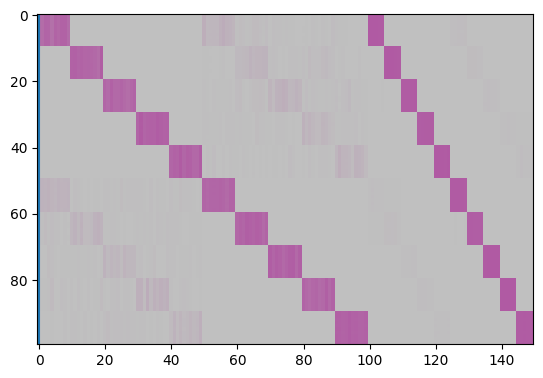

In [14]:
# Compute the full indexing array
full_ordered_indices = torch.cat([
    network.ordered_indices_mtl_dense,
    network.mtl_dense_size + network.ordered_indices_mtl_sparse
])

plt.imshow(network.ctx_mtl[network.ordered_indices_ctx[:100]][:, full_ordered_indices[:150]], cmap=gray_purple)
plt.axvline()

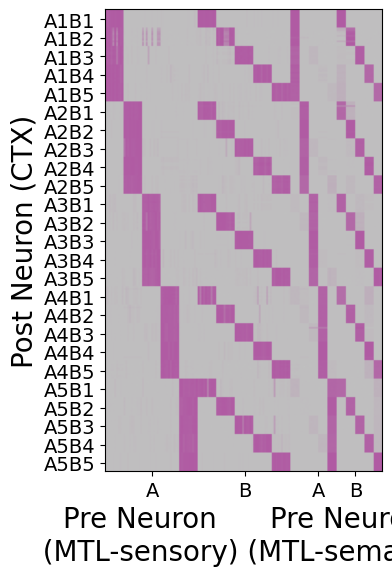

In [15]:
fig = plt.figure(figsize=(5, 6))

plt.imshow(network.ctx_mtl[network.ordered_indices_ctx_episodes[:250]][:, full_ordered_indices[:150]], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]



plt.yticks(positions_episodes, labels_episodes,  fontsize=14)
plt.xticks([25, 75, 115, 135], ["A", "B", "A", "B"],  fontsize=14)
plt.xlabel("Pre Neuron      Pre Neuron\n  (MTL-sensory) (MTL-semantic)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.savefig('Figures_SVG/7d.svg', dpi=300, transparent=True)


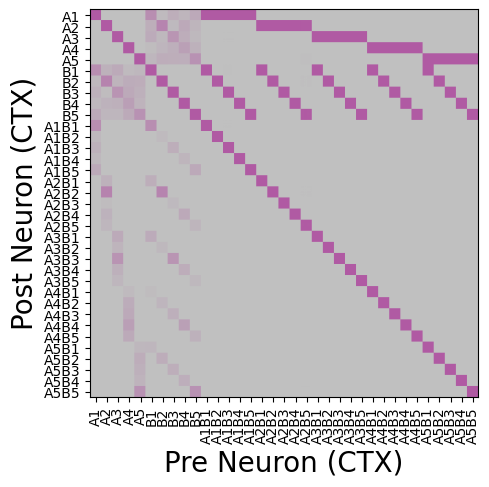

In [16]:
fig = plt.figure(figsize=(5, 6))


plt.imshow(network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)
plt.xticks(positions, labels, rotation=90)


plt.xlabel("Pre Neuron (CTX)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)

plt.savefig('Figures_SVG/7e.svg', dpi=300, transparent=True)


(0.0, 20000.0)

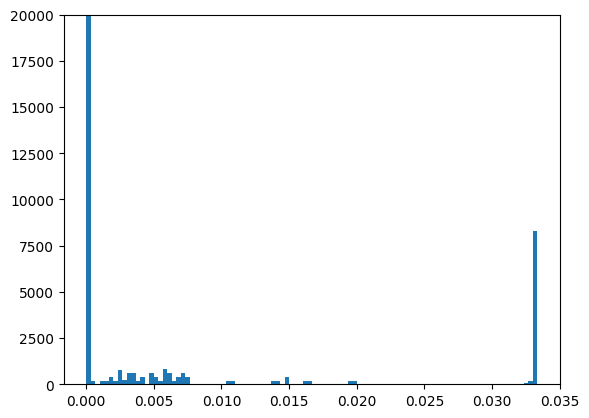

In [19]:
plt.hist(network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx].flatten(), bins=100)
plt.ylim([0, 20000])